imported necessary libraries

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
import time
import copy

checking if CUDA is available

In [53]:
print(f'torch version = {torch.__version__}')
#checking if CUDA is available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

torch version = 2.5.0+cu118
device = cuda


setting seed for reproducability

In [54]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

defining hyperparameters

In [55]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 10  # 9 diseases + normal
LEARNING_RATE = 0.001

defined my dataset path and transformations

In [56]:
DATASET_PATH = '.'
TRAIN_PATH = os.path.join(DATASET_PATH, 'more_train_images')

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

compiled dataset

In [57]:
train_dataset = ImageFolder(TRAIN_PATH, transform=train_transforms)
print(len(train_dataset))

16509


made a class to help with creating training and validation set

In [58]:
# Create subset datasets
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

made my training and validation set and their corresponding dataloaders

In [59]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Custom random split
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]


train_subset = SubsetDataset(train_dataset, train_indices)
val_subset = SubsetDataset(train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
class_names = train_dataset.classes

In [60]:
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [61]:
print(f"Classes: {class_names} \n")
print(f"Number of training samples: {len(train_subset)} \n")
print(f"Number of validation samples: {len(val_subset)}")

Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'] 

Number of training samples: 13207 

Number of validation samples: 3302


Defined my model , used the model trained with metadata and fine-tuned it

In [62]:
class DeiTWithMetadata(nn.Module):
    def __init__(self, num_classes, num_varieties):
        super().__init__()
        
        # Load Pretrained DeiT Model
        self.vision_model = timm.create_model("deit_base_patch16_224", pretrained=True, num_classes=0)  # No final classifier
        deit_feature_dim = 768  # DeiT output size
        
        # Metadata Processing FCNN
        self.variety_fc = nn.Linear(num_varieties, 64)  # Process variety metadata
        self.age_fc = nn.Linear(1, 16)  # Process age metadata
        
        # Combined feature dimension
        combined_dim = deit_feature_dim + 64 + 16  # 768 (DeiT) + 64 (variety) + 16 (age)
        
        # Final Classifier (Fusion of Image + Metadata)
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, variety, age):
        # Extract features from DeiT
        img_features = self.vision_model(image)  # (Batch, 768)
        
        # Process metadata
        variety_features = torch.relu(self.variety_fc(variety))  # (Batch, 64)
        age_features = torch.relu(self.age_fc(age))  # (Batch, 16)
        
        # Concatenate image & metadata features
        combined_features = torch.cat((img_features, variety_features, age_features), dim=1)  # (Batch, 768+64+16)
        
        # Final classification
        output = self.fc(combined_features)
        return output
    

class DeiTWithoutMetadata(nn.Module):
    def __init__(self, checkpoint_path,num_classes,):
        super().__init__()
        
        # Load Pretrained DeiT Model
        pretrained_model = DeiTWithMetadata(num_classes=num_classes, num_varieties=10)
        pretrained_model.load_state_dict(torch.load(checkpoint_path, map_location=device,weights_only=True))

        self.vision_model = pretrained_model.vision_model
        deit_feature_dim = 768  # DeiT output size
        
        # Final Classifier (Fusion of Image + Metadata)
        self.fc = nn.Sequential(
            nn.Linear(deit_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image):
        # Extract features from DeiT
        img_features = self.vision_model(image)  # (Batch, 768)
        
        
        # Final classification
        output = self.fc(img_features)
        return output

Defined a training function

In [63]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = GradScaler()  # Enable AMP (Mixed Precision Training)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'In phase {phase}')
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            print(f'Starting iteration over data')
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                  with autocast(device_type=str(device)):  # Mixed Precision Training
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        # loss.backward()
                        # optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

defined a function to evaluate my model

In [64]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    labels = list(range(len(train_dataset.classes)))
    report = classification_report(all_labels, all_preds,labels=labels, target_names=train_dataset.classes, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=labels)
    
    return report, conf_matrix, all_preds, all_labels

defined plotting function

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('Transformer_training_history_without_metadata.png')
    plt.show()

defined a function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('Transformer_confusion_matrix_without_metadata.png')
    plt.show()

trained my model

In [67]:
torch.cuda.empty_cache()
model = DeiTWithoutMetadata( 
    checkpoint_path="paddy_disease_transformer_with_metadata.pth",
    num_classes=len(train_dataset.classes), 
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

# Save the model
torch.save(model.state_dict(), f'paddy_disease_transformer_without_metadata.pth')

Epoch 1/20
----------
In phase train
Starting iteration over data
train Loss: 1.4431 Acc: 0.4520
In phase val
Starting iteration over data
val Loss: 1.2598 Acc: 0.5173

Epoch 2/20
----------
In phase train
Starting iteration over data
train Loss: 1.2668 Acc: 0.5140
In phase val
Starting iteration over data
val Loss: 1.1710 Acc: 0.5433

Epoch 3/20
----------
In phase train
Starting iteration over data
train Loss: 1.1649 Acc: 0.5495
In phase val
Starting iteration over data
val Loss: 1.0650 Acc: 0.5796

Epoch 4/20
----------
In phase train
Starting iteration over data
train Loss: 1.1120 Acc: 0.5645
In phase val
Starting iteration over data
val Loss: 1.0819 Acc: 0.5697

Epoch 5/20
----------
In phase train
Starting iteration over data
train Loss: 1.0402 Acc: 0.5897
In phase val
Starting iteration over data
val Loss: 1.0673 Acc: 0.5857

Epoch 6/20
----------
In phase train
Starting iteration over data
train Loss: 0.9967 Acc: 0.6080
In phase val
Starting iteration over data
val Loss: 0.9862

evaluated my model


Test Results:
Accuracy: 0.7353

Classification Report:
bacterial_leaf_blight: Precision: 0.9251, Recall: 0.8732, F1-Score: 0.8984
bacterial_leaf_streak: Precision: 0.7143, Recall: 0.6818, F1-Score: 0.6977
bacterial_panicle_blight: Precision: 0.6757, Recall: 0.7576, F1-Score: 0.7143
blast: Precision: 0.5821, Recall: 0.7134, F1-Score: 0.6411
brown_spot: Precision: 0.6021, Recall: 0.4388, F1-Score: 0.5076
dead_heart: Precision: 0.8625, Recall: 0.8996, F1-Score: 0.8807
downy_mildew: Precision: 0.7928, Recall: 0.6567, F1-Score: 0.7184
hispa: Precision: 0.7588, Recall: 0.7011, F1-Score: 0.7288
normal: Precision: 0.7277, Recall: 0.8105, F1-Score: 0.7669
tungro: Precision: 0.8618, Recall: 0.8886, F1-Score: 0.8750


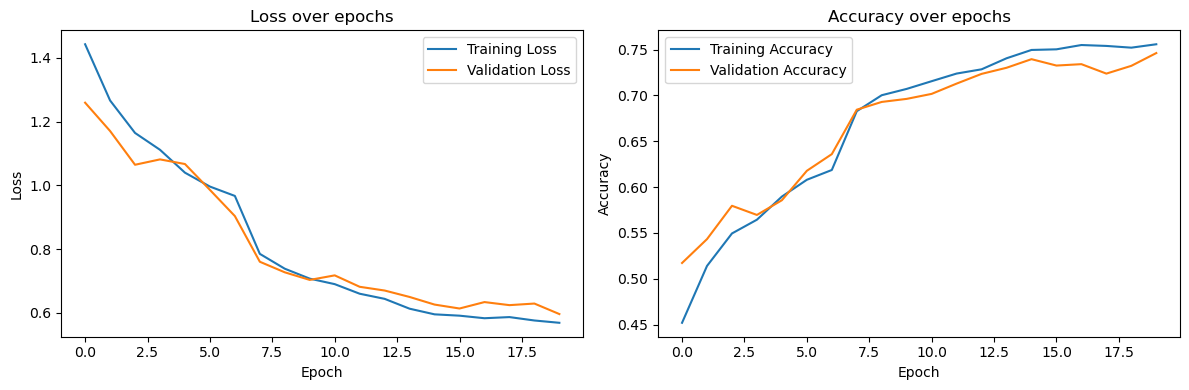

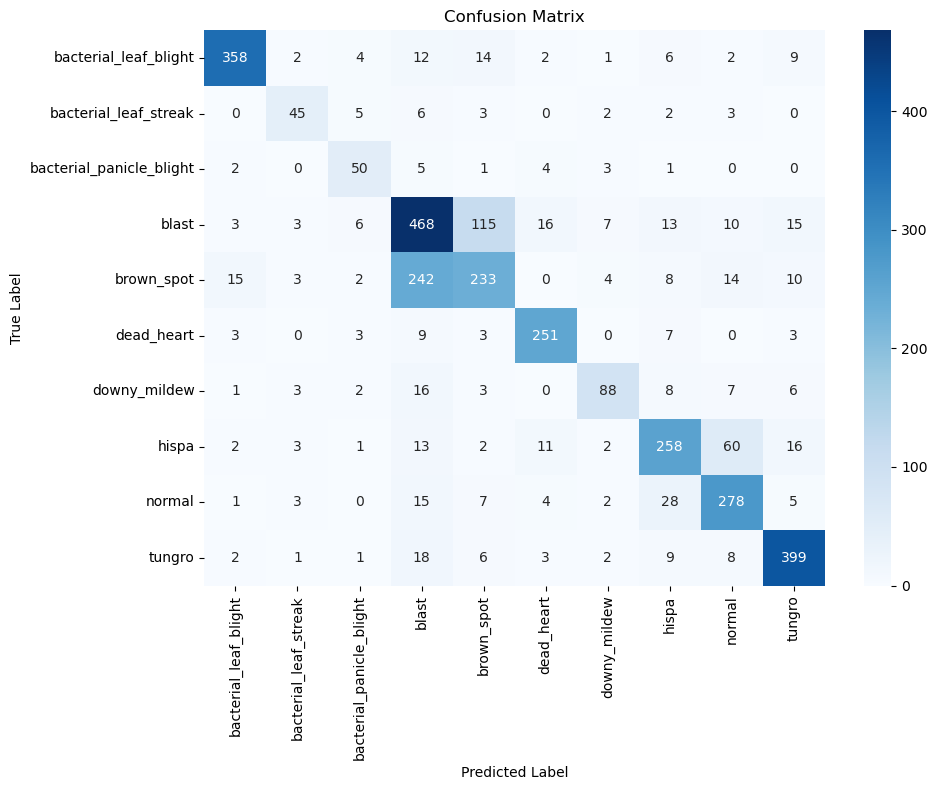

In [68]:
test_report, test_conf_matrix, test_preds, test_labels = evaluate_model(model, val_loader)

# Print test results
print("\nTest Results:")
print(f"Accuracy: {test_report['accuracy']:.4f}")
print("\nClassification Report:")
for class_name in train_dataset.classes:
    print(f"{class_name}: Precision: {test_report[class_name]['precision']:.4f}, "
            f"Recall: {test_report[class_name]['recall']:.4f}, "
            f"F1-Score: {test_report[class_name]['f1-score']:.4f}")

# Plot results
plot_training_history(history)
plot_confusion_matrix(test_conf_matrix, train_dataset.classes)

In [69]:
# # Train the model
# model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

# # Save the model
# torch.save(model.state_dict(), f'paddy_disease_transformer_without_metadata_new2.pth')

In [70]:
# test_report, test_conf_matrix, test_preds, test_labels = evaluate_model(model, val_loader)

# # Print test results
# print("\nTest Results:")
# print(f"Accuracy: {test_report['accuracy']:.4f}")
# print("\nClassification Report:")
# for class_name in train_dataset.classes:
#     print(f"{class_name}: Precision: {test_report[class_name]['precision']:.4f}, "
#             f"Recall: {test_report[class_name]['recall']:.4f}, "
#             f"F1-Score: {test_report[class_name]['f1-score']:.4f}")

# # Plot results
# plot_training_history(history)
# plot_confusion_matrix(test_conf_matrix, train_dataset.classes)